Table of Contents


In [52]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
import copy
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import randint as sp_randint
from pprint import pprint as ppimport 
from time import time
from operator import itemgetter


%matplotlib inline
os.getcwd()

'/home/ryan/Documents/insight_projects/steam_prices/data_analysis'

In [53]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

<H3>IMPORT STEAMDB FEATURES AND CLEAN MORE

In [54]:
df = pd.read_pickle('df_steamdb_timeseries.pkl')
since_sale_len = len(df.since_sale_lists[1])
print since_sale_len


21


<h4>data set choice parameters

In [55]:
current_epoch =  19 #the epoch in the bool list to predict
validation_set_prop = 0.20 #proportion of the entire data set to hold out for validation

In [56]:
#df.head()

drop_columns = ['fprice','iprice','price_date','sale_bool',
                'formatted_no_holiday','saledates_no_holiday',
               'sale_bool_all','min_iprice','mip_slopes','dirty_isi']
df_feat_space = df.drop(drop_columns,axis=1)
df_feat_space = df_feat_space[df_feat_space.formatted.map(type) != type([])]
#df_feat_space = df_feat_space.drop(['formatted'])
#df_feat_space['specific_epoch_time_since'] = df_feat_space.since_sale_lists[3]
#df.head()

In [57]:
'''empty list replace'''
replacement_empty_list = list(df.iloc[1].sale_bool_no_holiday[0] - df.iloc[1].sale_bool_no_holiday[0][0] + (60*60*24*100.0))
#if there are no values, for now just use this empty list that assumes the last sale was more than one hundred days ago
#however, this may be problematic if there's a negative correlation for games with sales and the time since the last game
#to_series = df_feat_space.since_sale_lists

to_series = df_feat_space.since_sale_lists
check = [x for x in to_series]
check_copy = copy.deepcopy(check)

just_one_epoch = list()
for i,v in enumerate(check):
    if v == []:
        check_copy[i] = replacement_empty_list
    cur_epoch_time_since = check_copy[i][current_epoch]
    just_one_epoch.append(cur_epoch_time_since)

df_feat_space['specific_epoch_time_since'] = just_one_epoch
#rint(check)
#[df_feat_space.head().iloc['since_sale_lists']

In [58]:
'''change boolean into 1 or 0'''
df_feat_space.has_price_slope = df_feat_space.has_price_slope.apply(lambda x:x*1)

In [59]:
'''make exponential cdf probability'''
day_sec = 60 * 60 * 24
twoweek_days = 14
time_since_ds = (df_feat_space.specific_epoch_time_since / day_sec) + 14
exp_lambda =  1/df_feat_space.dirty_isi_mean
df_feat_space['exp_cdf_time_since_prob'] =  1 - np.exp(-time_since_ds * exp_lambda)


<h3>STEAM SCRAPED FEATURES

In [60]:
df_steamscraped = pd.read_pickle('steam_features.pkl')

In [61]:
df_steamscraped.head()
drop_ss_cols = ['developer','game_name','meta_score','new_id','publisher','release_date','tag_data']
df_ss_features = df_steamscraped.drop(drop_ss_cols,axis =1)
df_ss_features.head()

,appid,time_stamp_rd,big_publisher,publisher_category,meta_score_mean_interpolate
0,317950,1416297600,False,small_publisher,72.40834
1,315940,1416297600,False,small_publisher,72.40834
2,363510,1416297600,False,small_publisher,72.40834
3,348870,1416297600,False,small_publisher,72.40834
4,348700,1416297600,False,small_publisher,72.40834


In [62]:
df_ss_features.big_publisher = df_ss_features.big_publisher.apply(lambda x:x*1) #turn into 1 or 0

In [63]:
unique_pubs = df_ss_features.publisher_category.unique()
le = LabelEncoder()
le.fit(df_ss_features.publisher_category)
df_ss_features['pub_cat_int'] = le.transform(df_ss_features.publisher_category)

<h4>integrate user tag clustering as a feature

In [64]:
df_tag = pd.read_pickle('df_kmeans.pkl')

In [65]:
df_tag_ss = pd.merge(left=df_ss_features,right=df_tag, left_on='appid', right_on='appid')

In [66]:
df_merged_features = pd.merge(left=df_tag_ss,right=df_feat_space, left_on='appid', right_on='appid')

In [67]:
df_merged_features['sale_count_x_dirty_isi_mean'] = df_merged_features.sale_count * df_merged_features.dirty_isi_mean
df_merged_features['exp_specific_epoch_time_since'] = np.exp(-df_merged_features.specific_epoch_time_since)
df_merged_features['sale_count_x_specific_epoch_time_since'] =df_merged_features.sale_count * df_merged_features.specific_epoch_time_since

In [68]:
def get_initial_price(formatted_prices_dict):
    out_med = np.median(np.array([float(v['initial'].strip('$')) 
              for v in formatted_prices_dict.itervalues()]))
    return out_med

df_merged_features['median_initial_price'] = df_merged_features.formatted.apply(get_initial_price)


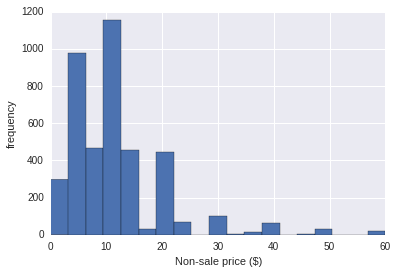

In [69]:
df_merged_features.median_initial_price.plot(kind='hist',bins = np.linspace(0,60,20))
plt.xlim([0,60])
plt.xlabel('Non-sale price ($)')
plt.ylabel('frequency')

In [70]:
'''make cluster initial price df'''
pickle_cluster = False
if pickle_cluster:
    df_merged_features[['appid', 
                        'median_initial_price',
                        'cluster']].to_pickle('df_price_cluster.pkl')


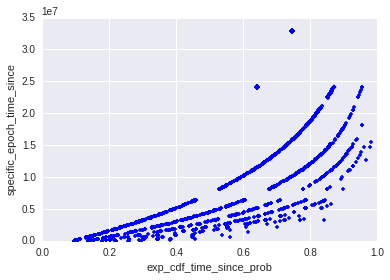

In [71]:
plt.plot(df_merged_features['exp_cdf_time_since_prob'],
         df_merged_features['specific_epoch_time_since'],
        'b.')
plt.xlabel('exp_cdf_time_since_prob')
plt.ylabel('specific_epoch_time_since')


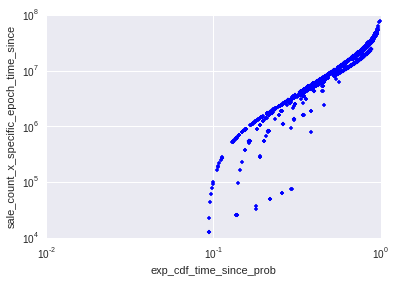

In [72]:
plt.plot(df_merged_features['exp_cdf_time_since_prob'],
         df_merged_features['sale_count_x_specific_epoch_time_since'],
        'b.')
plt.xlabel('exp_cdf_time_since_prob')
plt.ylabel('sale_count_x_specific_epoch_time_since')
plt.xscale('log')
plt.yscale('log')

<h4>make y values after tables are merged and everything else is calculated

In [73]:
'''make y values'''
yall = list()
for i,v in enumerate(df_merged_features.sale_bool_no_holiday):
    if v == []:
        y_in = 0
    else:
        y_in = v[1][current_epoch] #1 is the index of the boolean list
    yall.append(y_in)

yall = np.array(yall)

In [74]:

analyzed_appids = df_merged_features.appid
drop_more_columns = ['appid','formatted','since_sale_lists', 'sale_bool_no_holiday','publisher_category']
df_merged_features = df_merged_features.drop(drop_more_columns,axis=1)


In [75]:
feature_names = list(df_merged_features.columns.values)
print feature_names

['time_stamp_rd', 'big_publisher', 'meta_score_mean_interpolate', 'pub_cat_int', 'cluster', 'sale_count', 'has_price_slope', 'dirty_isi_mean', 'specific_epoch_time_since', 'exp_cdf_time_since_prob', 'sale_count_x_dirty_isi_mean', 'exp_specific_epoch_time_since', 'sale_count_x_specific_epoch_time_since', 'median_initial_price']


In [76]:
df_merged_features.head()

,time_stamp_rd,big_publisher,meta_score_mean_interpolate,pub_cat_int,cluster,sale_count,has_price_slope,dirty_isi_mean,specific_epoch_time_since,exp_cdf_time_since_prob,sale_count_x_dirty_isi_mean,exp_specific_epoch_time_since,sale_count_x_specific_epoch_time_since,median_initial_price
0,1416297600,0,72.40834,56,129,2,0,95.333333,1481476,0.278710,190.666667,0,2962952,2.99
1,1416297600,0,72.40834,56,151,2,0,96.000000,12367951,0.805428,192.000000,0,24735902,9.99
2,1416297600,0,72.40834,56,50,1,0,144.000000,1466852,0.193556,144.000000,0,1466852,9.99
3,1416297600,0,72.40834,56,180,3,0,71.750000,2899953,0.484654,215.250000,0,8699859,4.99
4,1416297600,0,69.00000,56,150,2,0,95.666667,2086318,0.328842,191.333333,0,4172636,9.99


In [77]:
Xall = df_merged_features.as_matrix().astype(np.float)

In [78]:
scaler = StandardScaler()
Xall = scaler.fit_transform(Xall)
#just learned that technically, this is incorrect, first you should do the split, then standardize the data

print "Feature space holds %d observations and %d features" % Xall.shape

Feature space holds 4163 observations and 14 features


<h4> split off a validation/hold out set

In [79]:
total_rows = yall.size
validation_size =  int(total_rows * 1.0 *  validation_set_prop)
validation_row_indices = np.sort(np.random.choice(range(total_rows),validation_size, replace = False))
traintest_row_indices =np.array(list(set(range(total_rows)) - set(list(validation_row_indices))))


In [80]:
Xv = Xall[validation_row_indices,:]
X = Xall[traintest_row_indices,:]

Yv = yall[validation_row_indices]
y = yall[traintest_row_indices]



<h4>run model

In [81]:

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred


In [82]:
def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))

Support vector machines:
0.936
Random forest:
0.969
K-nearest-neighbors:
0.923


In [83]:
chance_accuracy = (1 - sum(y)*1.0 / y.size)

In [84]:
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
]


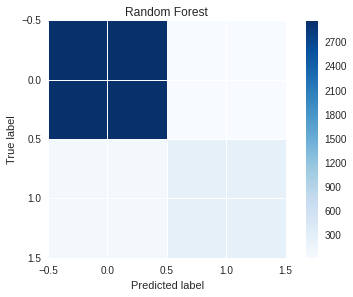

In [85]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(iris.target_names))
    #plt.xticks(tick_marks, iris.target_names, rotation=45)
    #plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


look_at_model = 1
plot_confusion_matrix(confusion_matrices[look_at_model][1],confusion_matrices[look_at_model][0])


<h4> Hyper parameter tuning

In [86]:
clf = RF(n_estimators=20)
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)
best_params = random_search.best_params_

RandomizedSearchCV took 15.25 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.970 (std: 0.004)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 2, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.969 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 3, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.969 (std: 0.005)
Parameters: {'bootstrap': False, 'min_samples_leaf': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 5, 'max_depth': None}



In [87]:
def run_prob_cv(X, y, clf_in):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2)) #2 is the number of classes (sale, or not)
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #y_train = y[train_index]
        clf = clf_in
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        y_prob_all = clf.predict_proba(X_test)
    return y_prob, y_test, y_prob_all, clf

In [88]:
import warnings
warnings.filterwarnings('ignore')

pred_prob,y_test,y_prob_all,clf = run_prob_cv(X, y, clf)
pred_sale = pred_prob[:,1]
is_sale = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_sale)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_sale[pred_sale == prob])
    true_prob = pd.Series(true_prob)
    
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.00,2577,0.002716
1,0.05,181,0.055249
2,1.00,141,1.000000
3,0.10,69,0.130435
4,0.15,56,0.107143
5,0.95,47,0.936170
6,0.20,31,0.161290
7,0.25,30,0.166667
8,0.35,26,0.230769
9,0.30,25,0.160000


In [89]:
'''save model if using epoch 19, to then be validated on epoch 20'''
if current_epoch == 19: #use epoch 19 to train, then explicitly examine results on epoch 20
    print
    joblib.dump(clf, 'epoch19_model.pkl')
    

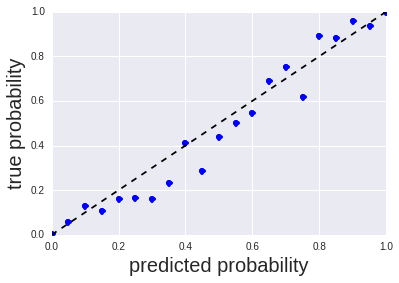

In [90]:
'''plot predicted probability by true probability'''
counts = counts.sort('pred_prob')
plt.plot(counts.pred_prob,counts.true_prob, 'bo')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('predicted probability', fontsize = 20)
plt.ylabel('true probability',fontsize = 20)

In [91]:
'''examine accuracy with validation / hold out set'''
Yv_predict = clf.predict(Xv)
accuracy(Yv,Yv_predict)

0.96033653846153844

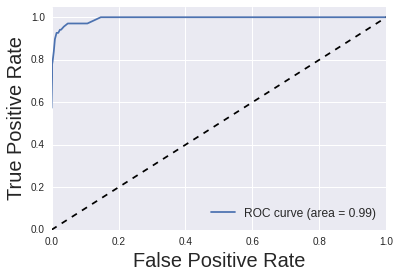

In [92]:
#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_prob_all[:,1] # 1 is the 'positive' class
fpr, tpr,_ =roc_curve(y_test,y_prob_all[:,1])
roc_auc= auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate',fontsize = 20)
#plt.title('RF Receiver Operating Characteristic', fontsize = 20)
plt.legend(loc="lower right", fontsize = 12)
#rf_fpr, rf_tpr, thresholds = roc_curve(y_test, pred_prob[:, 1])`

<h4> Determine most important features

In [93]:
etc_in = ETC(n_estimators = 20)
pred_prob,y_test,y_prob_all,clf_ETC = run_prob_cv(X, y, etc_in)
importances = clf_ETC.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 12 sale_count_x_specific_epoch_time_since (0.244757)
2. feature 9 exp_cdf_time_since_prob (0.217318)
3. feature 8 specific_epoch_time_since (0.213989)
4. feature 10 sale_count_x_dirty_isi_mean (0.074580)
5. feature 7 dirty_isi_mean (0.066012)
6. feature 4 cluster (0.048567)
7. feature 13 median_initial_price (0.040807)
8. feature 5 sale_count (0.039379)
9. feature 2 meta_score_mean_interpolate (0.022739)
10. feature 6 has_price_slope (0.015601)
11. feature 3 pub_cat_int (0.009735)
12. feature 1 big_publisher (0.006515)
13. feature 11 exp_specific_epoch_time_since (0.000000)
14. feature 0 time_stamp_rd (0.000000)


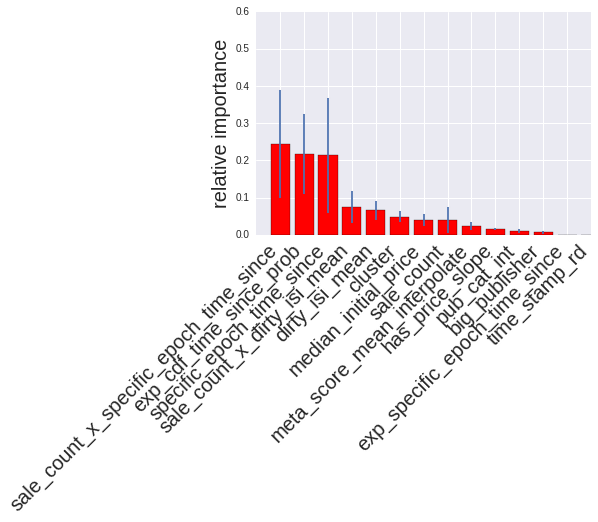

In [94]:
print("Feature ranking:")

for f in range(len(feature_names)):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], feature_names[indices[f]], importances[indices[f]]))

fig, ax = plt.subplots(1)
#ax.set_title("Feature importances")
ax.bar(range(len(feature_names)), importances[indices], color="r", yerr=std[indices], align="center")

ax.set_xlim([-1, 10])
ax.set_ylim([0,0.6])
#x.set_xlabel('feature')
ax.set_ylabel('relative importance', fontsize = 20)
ax.set_xticks(range(len(feature_names)))

feature_names_sorted = [feature_names[i] for i in indices] 
#
#     feature_names_sorted = ['time since last sale', 
#                         'time since x # of sales', 
#                         'mean inter-sale time',
#                        'sale count x mean isi',
#                         'review scores',
#                         '# of sales',
#                         'price decay',
#                         'publisher',
#                         'big publisher',
#                         '',
#                         '',]
                        
ax.set_xticklabels(feature_names_sorted, rotation='45', fontsize = 20, ha='right')

In [103]:
class RandomForestClassifierWithCoef(RF):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_

rfcc = RandomForestClassifierWithCoef()
rfecv = RFECV(estimator=rfcc, step=1, cv=StratifiedKFold(y, 2),scoring='f1')
rfecv.fit(X, y)


print("Optimal number of features : %d" % rfecv.n_features_)
rfecv.ranking_


Optimal number of features : 9


array([6, 3, 1, 2, 1, 1, 4, 1, 1, 1, 1, 5, 1, 1])

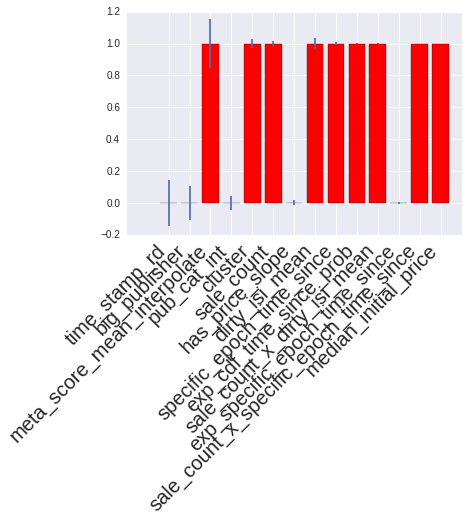

In [104]:
fig, ax = plt.subplots(1)
ax.bar(range(len(feature_names)), 1/rfecv.ranking_, color="r", yerr=std[indices], align="center")
ax.set_xticks(range(len(feature_names)))

ax.set_xticklabels(feature_names,rotation='45', fontsize = 20, ha='right')

<h4>make probability data_frame

In [97]:
Yall_sale_prop = clf.predict_proba(Xall)[:,1] #1 is the probability of a sale

In [98]:
df_app_sale_prob = pd.DataFrame({'appid':analyzed_appids,'sale_prob': Yall_sale_prop}) 
#turn this into a moving window for later

In [99]:
#df_app_sale_prob.to_pickle('df_sale_prob.pkl')

In [100]:
pd.value_counts(pd.Series(clf.predict_proba(Xall)[:,1]))

0.00    3337
1.00     218
0.05     179
0.10      69
0.15      59
0.95      40
0.20      33
0.85      28
0.90      25
0.25      25
0.80      21
0.65      19
0.30      17
0.50      15
0.60      13
0.70      13
0.45      12
0.75      11
0.35      10
0.40      10
0.55       9
dtype: int64

<h3>Validate Entire Model by testing on an epoch previously trained and tested

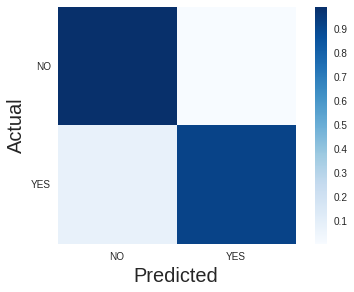

In [101]:
if current_epoch == 20:
    e19_clf = joblib.load('epoch19_model.pkl') 
    Yall_predict = clf.predict(Xall)
    cm = confusion_matrix(yall, Yall_predict)
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
    plt.xticks([1,0])
    plt.yticks([0,1])
    plt.gca().set_yticklabels(['NO','YES'])
    plt.gca().set_xticklabels(['YES','NO'])
    xlabel = ['Actual']
    plt.xlabel('Predicted', fontsize = 20)
    plt.ylabel('Actual',fontsize = 20)
    plt.grid(False)
    plt.title('')
    

In [102]:
print cm_normalized

[[ 0.99  0.01]
 [ 0.08  0.92]]
